In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, auc
)
import gender_guesser.detector as gender
import warnings
import joblib
warnings.filterwarnings("ignore")


In [2]:
def read_datasets():
    genuine_users = pd.read_csv("users.csv")
    fake_users = pd.read_csv("fusers.csv")
    x = pd.concat([fake_users, genuine_users], ignore_index=True)
    y = [0] * len(fake_users) + [1] * len(genuine_users)  # 0 = Fake, 1 = Genuine
    return x, y

In [3]:
def predict_sex(name_series):
    detector = gender.Detector(case_sensitive=False)
    first_names = name_series.str.split(' ').str.get(0).fillna('')
    sex = first_names.apply(detector.get_gender)
    sex_map = {'female': -2, 'mostly_female': -1, 'unknown': 0, 'mostly_male': 1, 'male': 2}
    return sex.map(sex_map).fillna(0).astype(int)

In [4]:
def extract_features(df):
    df['name'] = df['name'].fillna('')
    df['sex_code'] = predict_sex(df['name'])

    # Safe calculations (avoid division by zero)
    df['follow_ratio'] = df['followers_count'] / (df['friends_count'] + 1)
    df['posts_per_follower'] = df['statuses_count'] / (df['followers_count'] + 1)
    df['name_length'] = df['name'].apply(lambda x: len(str(x)))
    df['ff_diff'] = df['followers_count'] - df['friends_count']
    df['activity_score'] = df['statuses_count'] + df['favourites_count']  # removed listed_count here

    if 'description' in df.columns:
        df['desc_length'] = df['description'].fillna('').apply(len)

    features = [
        'statuses_count', 'followers_count', 'friends_count',
        'favourites_count', 'sex_code', 'follow_ratio',
        'name_length', 'posts_per_follower', 'ff_diff', 'activity_score'
    ]

    if 'desc_length' in df.columns:
        features.append('desc_length')

    X = df[features]
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    return X


In [5]:
def train_and_evaluate(X, y):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC

    # Scores
    acc = accuracy_score(y_test, y_pred)
    loss_percentage = (1 - acc) * 100

    print("Accuracy:", acc)
    print(f"Loss Percentage: {loss_percentage:.2f}%")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Fake', 'Genuine']))
    
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"Cross-validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    # Feature Importances
    print("\nFeature Importances:")
    importances = clf.feature_importances_
    for f, imp in zip(X_train.columns, importances):
        print(f"{f}: {imp:.4f}")

    # Plot Confusion Matrix
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Fake', 'Genuine'])

    # Plot ROC Curve
    plot_roc_curve(y_test, y_pred_prob)
    


In [6]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [7]:
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [8]:
def train_and_evaluate(X, y):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    clf = RandomForestClassifier(n_estimators=40, oob_score=True, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC

    # ---------- Scores ----------
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)

    # 🔴 Loss Percentage = (1 - Accuracy) * 100
    loss_percentage = (1 - acc) * 100
    print(f"Loss Percentage: {loss_percentage:.2f}%")

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Fake', 'Genuine']))

    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"Cross-validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    # ---------- Feature Importances ----------
    print("\nFeature Importances:")
    importances = clf.feature_importances_
    for f, imp in zip(X_train.columns, importances):
        print(f"{f}: {imp:.4f}")

    # ---------- Plots ----------
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Fake', 'Genuine'])
    plot_roc_curve(y_test, y_pred_prob)


Loading data...
Extracting features...
Training and evaluating model...
Accuracy: 0.939875
Loss Percentage: 6.01%
Confusion Matrix:
 [[3722  278]
 [ 203 3797]]
Classification Report:
               precision    recall  f1-score   support

        Fake       0.95      0.93      0.94      4000
     Genuine       0.93      0.95      0.94      4000

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000

Cross-validation Accuracy: 0.9427 ± 0.0028

Feature Importances:
statuses_count: 0.0361
followers_count: 0.1803
friends_count: 0.1260
favourites_count: 0.2152
sex_code: 0.0044
follow_ratio: 0.0377
name_length: 0.0113
posts_per_follower: 0.0727
ff_diff: 0.1341
activity_score: 0.1194
desc_length: 0.0626


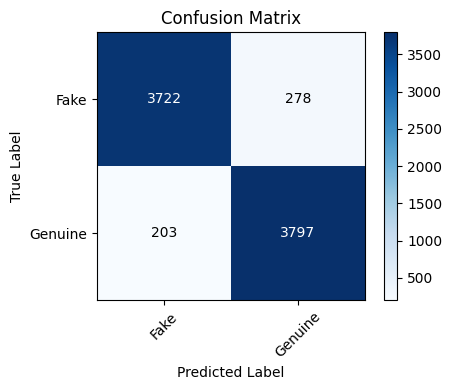

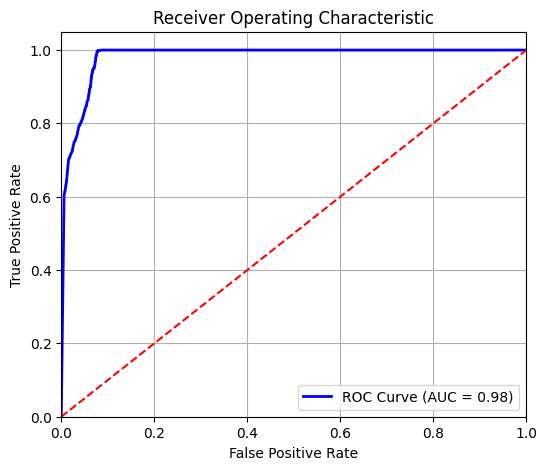

In [9]:
print("Loading data...")
x, y = read_datasets()

print("Extracting features...")
x = extract_features(x)

print("Training and evaluating model...")
train_and_evaluate(x, y)
